In [4]:
import pandas as pd 
import re
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from PIL import Image

from load_classes import fetch_classdict

In [43]:
metadf = pd.read_csv('../ODIR-data/full_df.csv')
class_dict = fetch_classdict()

In [49]:
metadf.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


### To do 
- [x] The class columns and the target-labels mentioned in the dataframe are unreliable, so we need to re-create them from the actual columns itself.
- [ ]  Re-engineering the paths to fit the current file structure.
- [ ]  A pipeline script which takes a particular patient_id and prints a subplot of both left_right fundus with their diagnosis as the title.

### Generating Class Labels

In [50]:
classes = list(metadf.columns[7:15])
metadf['Labels'] = metadf.apply(lambda x: [class_ for class_ in classes if x[class_]==1], axis=1)
metadf.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename,Labels
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,[C]
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,[N]
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,"[D, O]"
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,"[D, O]"
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,[D]


### Mapping Diagnosis with Class Labels

In [51]:
def map_diagnosis(item):
    diagnosis = []
    for label in item:
        diagnosis.append(class_dict[label])
    return diagnosis


In [52]:
metadf['Diagnosis'] = metadf['Labels'].apply(map_diagnosis)

In [53]:
metadf['Count'] = metadf['Diagnosis'].apply(lambda x:len(x))

In [54]:
cols = metadf.columns
newcols = pd.Series(cols).replace(class_dict).to_list()
n_metadf = metadf.copy(deep=True)
n_metadf.columns = newcols
n_metadf.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Normal,Diabetes,Glaucoma,...,Hypertension,Pathological,Other,filepath,labels,target,filename,Labels,Diagnosis,Count
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,[C],[Cataract],1
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,[N],[Normal],1
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,"[D, O]","[Diabetes, Other]",2


### To do 
- [x] The class columns and the target-labels mentioned in the dataframe are unreliable, so we need to re-create them from the actual columns itself.
- [x]  Re-engineering the paths to fit the current file structure.
- [ ]  A pipeline script which takes a particular patient_id and prints a subplot of both left_right fundus with their diagnosis as the title.

In [58]:
# Data Frame Structure
# - ../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/0_right.jpg
# Intended Structure
# - ../ODIR-data/ODIR-5K/ODIR-5K/Training Images/0_right.jpg

In [59]:
# Path restoration
sample_path = n_metadf['filepath'][0]
sample_path

'../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/0_right.jpg'

In [60]:
# split and rejoin the wanted elements
sample_path = sample_path.split('/')[3:]
sample_path.insert(0, 'ODIR-5K')

In [61]:
# testing
sample_path = os.path.join('../','ODIR-data','/'.join(sample_path))
sample_path

'../ODIR-data/ODIR-5K/ODIR-5K/Training Images/0_right.jpg'

In [62]:
# map function
def restructure_path(path):
    pathlist = path.split('/')[3:]
    pathlist.insert(0,'ODIR-5K')
    final_path = os.path.join('../','ODIR-data','/'.join(pathlist))
    return final_path

In [63]:
# Mapping Path Restoration
n_metadf['filepath'] = n_metadf['filepath'].apply(restructure_path)

In [64]:
n_metadf.head(2)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Normal,Diabetes,Glaucoma,Cataract,Age,Hypertension,Pathological,Other,filepath,filename,Labels,Diagnosis,Count
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/0...,0_right.jpg,[C],[Cataract],1
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/1...,1_right.jpg,[N],[Normal],1


In [ ]:
# test
# Image.open(n_metadf['filepath'][0]) -- passed

In [65]:
# Sorting
n_metadf = n_metadf.sort_values(by='ID')
n_metadf.reset_index(inplace=True,drop=True)
n_metadf.head(2)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Normal,Diabetes,Glaucoma,Cataract,Age,Hypertension,Pathological,Other,filepath,filename,Labels,Diagnosis,Count
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/0...,0_right.jpg,[C],[Cataract],1
1,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/0...,0_left.jpg,[C],[Cataract],1


In [67]:
# saving progress
n_metadf.to_csv('metadata.csv')

### Accurate Pairing

In [5]:
n_metadf[n_metadf['']]

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Normal,Diabetes,Glaucoma,Cataract,Age,Hypertension,Pathological,Other,filepath,filename,True_Labels,Diagnosis
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/0...,0_right.jpg,C,Cataract
1,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/0...,0_left.jpg,C,Cataract
2,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/1...,1_left.jpg,N,Normal
3,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/1...,1_right.jpg,N,Normal
4,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/2...,2_right.jpg,D,Diabetes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/4...,4689_left.jpg,D,Diabetes
6388,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/4...,4690_left.jpg,D,Diabetes
6389,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/4...,4690_right.jpg,D,Diabetes
6390,4784,58,Male,4784_left.jpg,4784_right.jpg,hypertensive retinopathy，age-related macular d...,hypertensive retinopathy，age-related macular d...,0,0,0,0,1,1,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/4...,4784_right.jpg,A,Age


In [407]:
n_metadf['ID'].value_counts()[n_metadf['ID'].value_counts()==1].index.sort_values()

Int64Index([   2,    3,   22,   25,   38,   39,   41,   50,   59,   63,
            ...
            4394, 4427, 4442, 4448, 4460, 4522, 4551, 4580, 4601, 4659],
           dtype='int64', length=324)

In [409]:
n_metadf[n_metadf['filename']=='2_left.jpg']

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Normal,Diabetes,Glaucoma,Cataract,Age,Hypertension,Pathological,Other,filepath,filename,True_Labels,Diagnosis


### To do 
- [x] The class columns and the target-labels mentioned in the dataframe are unreliable, so we need to re-create them from the actual columns itself.
- [x]  Re-engineering the paths to fit the current file structure.
- [x]  A pipeline script which takes a particular patient_id and prints a subplot of both left_right fundus with their diagnosis as the title.

### PipeLine to Plot Fundus Images

In [275]:
# Things to take into account
'''
* File name format, ID_{left | right}.jpg
'''

'\n* File name format, ID_{left | right}.jpg\n'

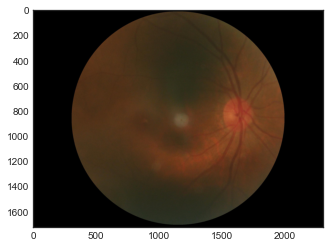

In [276]:
# testing 
plt.style.use('seaborn-white')
sample_image = n_metadf['filepath'][0]
plt.imshow(np.array(Image.open(sample_image)))
plt.grid = False

In [339]:
n_metadf.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Normal,Diabetes,Glaucoma,Cataract,Age,Hypertension,Pathological,Other,filepath,filename,True_Labels,Diagnosis
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/0...,0_right.jpg,C,Cataract
1,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/0...,0_left.jpg,C,Cataract
2,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/1...,1_left.jpg,N,Normal
3,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/1...,1_right.jpg,N,Normal
4,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/2...,2_right.jpg,D,Diabetes
5,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/3...,3_left.jpg,O,Other
6,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/4...,4_right.jpg,D,Diabetes
7,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/4...,4_left.jpg,D,Diabetes
8,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/5...,5_left.jpg,D,Diabetes
9,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/5...,5_right.jpg,D,Diabetes


In [ ]:
# Read the paired_df

In [6]:
paired_df = pd.read_csv('paired_df.csv').drop('Unnamed: 0',axis=1)
paired_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Normal,Diabetes,Glaucoma,Cataract,Age,Hypertension,Pathological,Other,filepath,filename,Labels,Diagnosis,Count
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/0...,0_right.jpg,['C'],['Cataract'],1
1,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/0...,0_left.jpg,['C'],['Cataract'],1
2,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/1...,1_left.jpg,['N'],['Normal'],1
3,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/1...,1_right.jpg,['N'],['Normal'],1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../ODIR-data/ODIR-5K/ODIR-5K/Training Images/4...,4_right.jpg,"['D', 'O']","['Diabetes', 'Other']",2


In [63]:
def plot_fundus(idx, paired_df, diagnosis=None):
    docs ='''
= Takes the ID number of the Patient and plots the patient's fundus Imagery ( Left | Right ).
- ID Range: 1-4784.
    '''
    # presets
    plt.style.use('dark_background')
    path_structure = '../ODIR-data/ODIR-5K/ODIR-5K/Training Images/'
    
    if diagnosis == None:
        # forging data
        left_f = os.path.join(path_structure, f'{idx}_left.jpg')
        right_f = os.path.join(path_structure, f'{idx}_right.jpg')
        left_arr = plt.imread(left_f)
        right_arr = plt.imread(right_f)

        # Patient Data
        diagnosis = paired_df[paired_df['ID'] == idx]['Diagnosis'].values[0]

    else:
        try:
            diagnosis_df = paired_df[paired_df['Diagnosis'].str.contains(diagnosis)]
            idx = diagnosis_df.iloc[0,:]['ID']
            left_f = os.path.join(path_structure, f'{idx}_left.jpg')
            right_f = os.path.join(path_structure, f'{idx}_right.jpg')
            left_arr = plt.imread(left_f)
            right_arr = plt.imread(right_f)

        except:
            print(f'No records found for {diagnosis}')
        
    fig, axs = plt.subplots(ncols=2,figsize=(15,7))

    axs[0].set_title(f'Left Fundus',size=15)
    axs[0].imshow(left_arr)

    axs[1].set_title(f'Right Fundus',size=15)
    axs[1].imshow(right_arr)

    fig.suptitle(f'Patient ID: {idx}, Diagnosis - {diagnosis}',size=20)
    plt.show()
    plt.savefig(f'Patient_ID{idx}')


dict_values(['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'Age', 'Hypertension', 'Pathological', 'Other'])


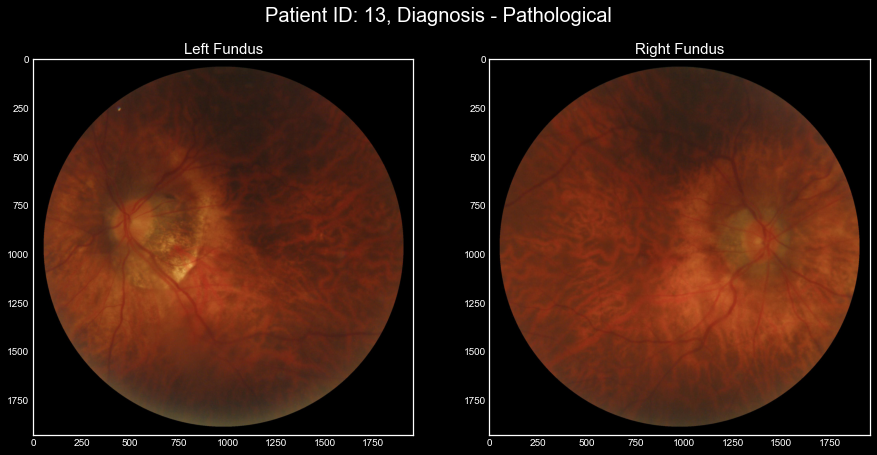

<Figure size 432x288 with 0 Axes>

In [64]:
class_dict = fetch_classdict().values()
print(class_dict)
plot_fundus(392, paired_df, diagnosis='Pathological')
